In [2]:
import cv2
import numpy as np
import os
import glob
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    image = cv2.resize(image, (256, 256))  # Resize for consistency
    
    # Apply Gaussian Blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply Histogram Equalization for contrast enhancement
    image = cv2.equalizeHist(image)
    
    return image

# Function to extract features
def extract_features(image):
    # Texture Features using GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    # Statistical Features
    mean = np.mean(image)
    std_dev = np.std(image)
    variance = np.var(image)
    
    return [contrast, energy, homogeneity, correlation, mean, std_dev, variance]

# Load dataset
def load_dataset(folder_path, label):
    images = []
    labels = []
    
    for file in glob.glob(os.path.join(folder_path, "*.*")):  # Modify for PNG or other formats
        image = preprocess_image(file)
        features = extract_features(image)
        images.append(features)
        labels.append(label)
    
    return images, labels

# Define dataset paths (Update with actual dataset directories)
cancer_images_path = "C:\\Users\\MAZIKEEN\\OneDrive\\Desktop\\cancer"  # Folder containing cancerous bone images
normal_images_path = "C:\\Users\\MAZIKEEN\\OneDrive\\Desktop\\normal" # Folder containing normal bone images

# Load data
cancer_features, cancer_labels = load_dataset(cancer_images_path, 1)  # 1 = Cancer
normal_features, normal_labels = load_dataset(normal_images_path, 0)  # 0 = Normal

# Combine and split dataset
X = np.array(cancer_features + normal_features)
y = np.array(cancer_labels + normal_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Bone Tumor Detection Accuracy: {accuracy * 100:.2f}%")

# Function to classify a new image
def classify_image(image_path):
    image = preprocess_image(image_path)
    features = extract_features(image)
    prediction = svm_model.predict([features])
    
    if prediction[0] == 1:
        print("Bone Tumor Detected!")
    else:
        print("No Bone Tumor Detected.")

# Test on a new image
test_image_path = "C:\\Users\\MAZIKEEN\\Downloads\\images.jpeg" # Replace with an actual test image path
classify_image(test_image_path)


Bone Tumor Detection Accuracy: 61.20%
Bone Tumor Detected!


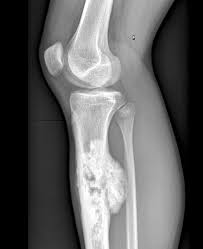

Original Image


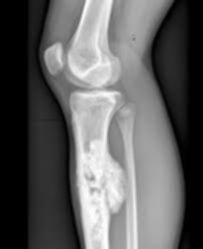

Box Filtered Image (Custom Kernel)


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
testimg=cv2.imread(test_image_path,0)

#Applying averaging filter
kernel = np.array([[1, 1, 1], 
                   [1, 1, 1], 
                   [1, 1, 1]]) 

# Normalize the kernel (important for a proper box filter)
kernel = kernel / np.sum(kernel) 

# Apply the filter using cv2.filter2D
box_filtered_image = cv2.filter2D(testimg, -1, kernel) 

# Display the results
display(Image.fromarray(testimg))
print("Original Image")

display(Image.fromarray(box_filtered_image))
print("Box Filtered Image (Custom Kernel)")


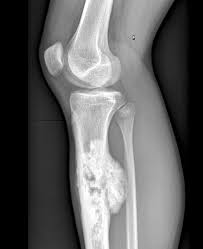

Original Image


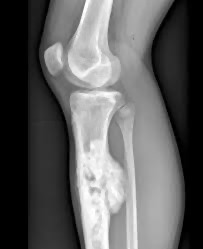

Box Filtered Image (Custom Kernel)


In [6]:
#Applying Median Filter
 
def median_filter(image, kernel_size=3):
    # Get the dimensions of the image
    height, width = image.shape
    
    # Create an output image of the same size, initialized to 0
    output_image = np.zeros_like(image)

    # Pad the image to handle borders
    pad_size = kernel_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    # Apply the median filter
    for i in range(height):
        for j in range(width):
            # Extract the region of interest (ROI) around the current pixel
            roi = padded_image[i:i+kernel_size, j:j+kernel_size]
            
            # Compute the median of the ROI and assign it to the current pixel
            output_image[i, j] = np.median(roi)

    return output_image


# Apply the median filter
filtered_image = median_filter(testimg, kernel_size=3)

# Show the original and filtered images
# Display the results
display(Image.fromarray(testimg))
print("Original Image")

display(Image.fromarray(filtered_image))
print("Box Filtered Image (Custom Kernel)")



sobel Filter


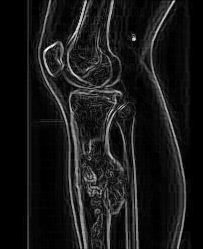

In [7]:
sobel_x_kernel = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])
sobel_y_kernel = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])

sobelx = cv2.filter2D(testimg, cv2.CV_64F, sobel_x_kernel)
sobely = cv2.filter2D(testimg, cv2.CV_64F, sobel_y_kernel)

abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)

sobel_img = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)
print("sobel Filter")
display(Image.fromarray(sobel_img));

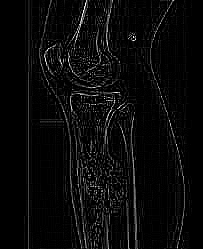

Laplacian Filtered Image


In [8]:
#laplacian filter

laplacian_kernel = np.array([[-1,-1, -1],
                            [-1, 8, -1],
                             [-1, -1, -1]])

# Apply the filter using cv2.filter2D
laplacian_filtered = cv2.filter2D(testimg, -1, laplacian_kernel)

# Display the results

display(Image.fromarray(laplacian_filtered))
print("Laplacian Filtered Image")

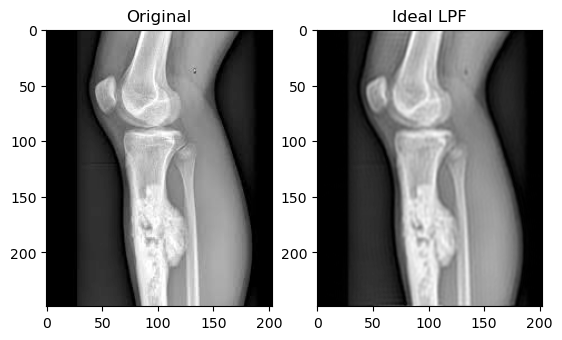

In [11]:
#Ideal High Pass

rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth LPF mask
D0 = 50  # Cutoff frequency
H = np.zeros((rows, cols), np.float32 )

for u in range(rows):
    for v in range(cols):
        if np.sqrt((u - crow) ** 2 + (v - ccol) ** 2) <= D0:
            H[u, v] = 1
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Ideal LPF')
plt.show()

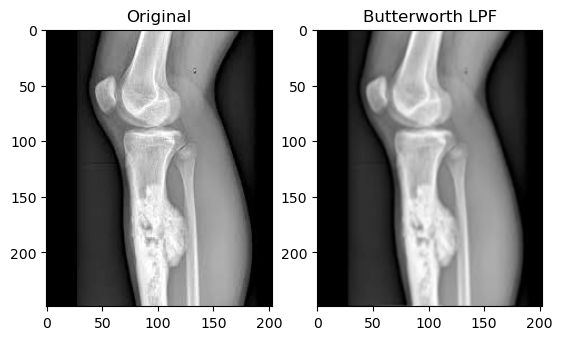

In [13]:
#Butterworth LPF
rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth LPF mask
H = np.zeros((rows, cols), dtype=np.float32)
for u in range(rows):
 for v in range(cols):
     D = np.sqrt((u - crow)**2 + (v - ccol)**2)
     H[u, v] = 1 / (1 + (D / D0)**(2 * n))
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Butterworth LPF')
plt.show()

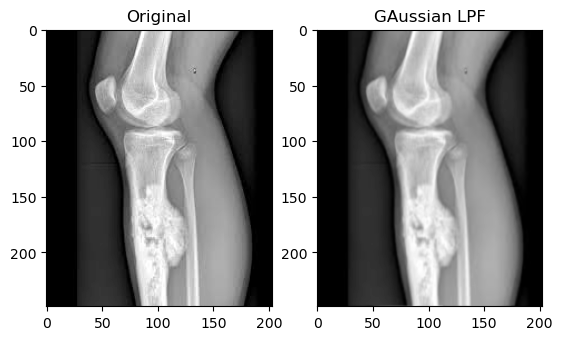

In [14]:
#Gaussian LPF
rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth LPF mask
H = np.zeros((rows, cols), dtype=np.float32)
for u in range(rows):
 for v in range(cols):
     D = np.sqrt((u - crow)**2 + (v - ccol)**2)
     H[u, v] = np.exp(-(D**2) / (2 * (D0**2)))
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Gaussian LPF')
plt.show()

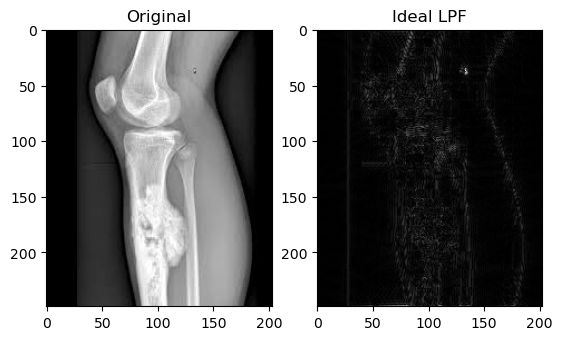

In [15]:
#Ideal HPF
rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth LPF mask
D0 = 50  # Cutoff frequency
H = np.zeros((rows, cols), np.float32 )

for u in range(rows):
    for v in range(cols):
        if np.sqrt((u - crow) ** 2 + (v - ccol) ** 2) > D0:
            H[u, v] = 1
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Ideal LPF')
plt.show()

C:\Users\MAZIKEEN\AppData\Local\Temp\ipykernel_7716\1985804970.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  H[u, v] = 1 / (1 + (D0 / D)**(2 * n))


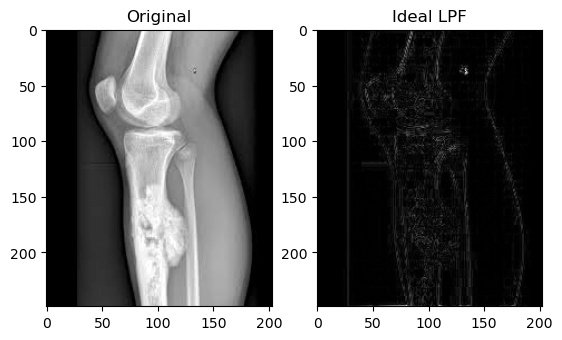

In [16]:
#Butterworth HPF
rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth HPF mask
D0 = 50  # Cutoff frequency
H = np.zeros((rows, cols), np.float32 )

for u in range(rows):
 for v in range(cols):
     D = np.sqrt((u - crow)**2 + (v - ccol)**2)
     H[u, v] = 1 / (1 + (D0 / D)**(2 * n))
     
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Butterwoth HPF')
plt.show()

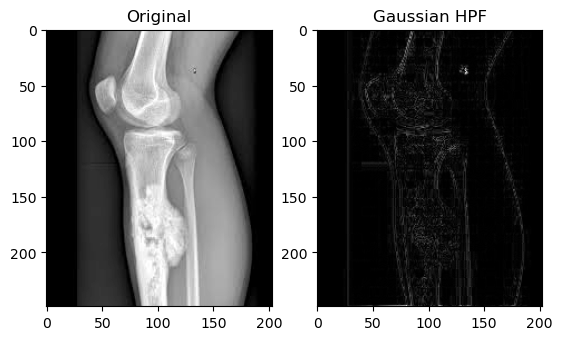

In [17]:
#Butterworth HPF
rows, cols = testimg.shape
crow, ccol = rows//2 , cols//2
 # Fourier transform
dft = np.fft.fft2(testimg)
dft_shift = np.fft.fftshift(dft)
 # Butterworth filter parameters
D0 = 50  # cutoff frequency
n = 2    # order of the filter
 # Create Butterworth HPF mask
D0 = 50  # Cutoff frequency
H = np.zeros((rows, cols), np.float32 )

for u in range(rows):
 for v in range(cols):
     D = np.sqrt((u - crow)**2 + (v - ccol)**2)
     H[u, v] = 1-np.exp(-(D**2) / (2 * (D0**2)))
# Apply filter
filtered_dft = dft_shift * H
 # Inverse FFT
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
 # Display
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Gaussian HPF')
plt.show()

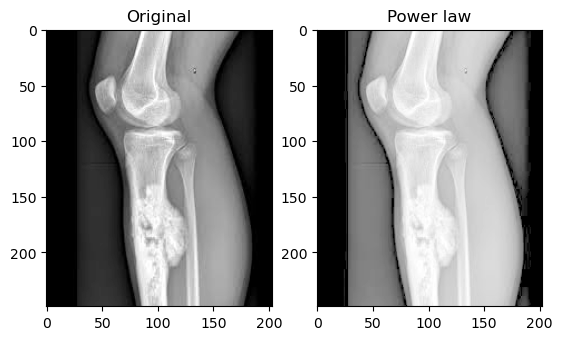

In [20]:
#Point Processing (Power Law)
# Normalize image to [0,1] range
normalized = testimg / 255.0

# --- Apply power-law transformation ---
gamma = 0.4  # try values like 0.4 (bright) or 2.0 (dark)
power_law = np.power(normalized, gamma)

# Scale back to [0,255]
result = np.uint8(power_law * 255)

# Show and save 
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Power law')
plt.show()
    

C:\Users\MAZIKEEN\AppData\Local\Temp\ipykernel_7716\3781954152.py:7: RuntimeWarning: invalid value encountered in divide
  filtered_img = np.where(denominator != 0, numerator / denominator, img)


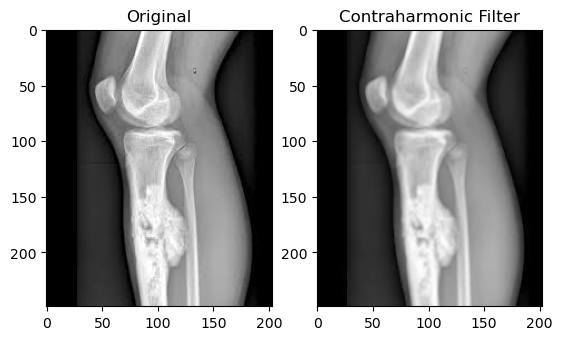

In [22]:
# Function to apply Contraharmonic Mean Filter
def contraharmonic_mean_filter(img, kernel_size, Q):
  
  kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
  numerator = cv2.filter2D(img.astype(np.float32)**(Q + 1), -1, kernel)
  denominator = cv2.filter2D(img.astype(np.float32)**Q, -1, kernel)
  filtered_img = np.where(denominator != 0, numerator / denominator, img)
  return filtered_img.astype(np.uint8)

# Apply Contraharmonic Mean Filter to your image
filtered_img = contraharmonic_mean_filter(testimg, kernel_size=3, Q=-1.5) # Adjust kernel_size and Q as needed salt


# Show and save 
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(filtered_img, cmap='gray'), plt.title('Contraharmonic Filter')
plt.show()

C:\Users\MAZIKEEN\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\MAZIKEEN\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\MAZIKEEN\AppData\Local\Temp\ipykernel_7716\2469010770.py:10: RuntimeWarning: invalid value encountered in cast
  filtered_img[i, j] = np.mean(trimmed_neighborhood)


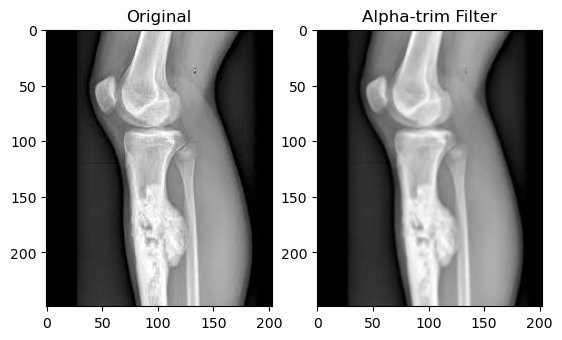

In [24]:
# Function to apply Alpha-trimmed Mean Filter
def alpha_trimmed_mean_filter(img, kernel_size, d):
 
  filtered_img = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      neighborhood = img[max(0, i - kernel_size // 2):min(img.shape[0], i + kernel_size // 2 + 1),
                         max(0, j - kernel_size // 2):min(img.shape[1], j + kernel_size // 2 + 1)]
      trimmed_neighborhood = np.sort(neighborhood.flatten())[d:-d] # Trim extreme values
      filtered_img[i, j] = np.mean(trimmed_neighborhood)
  return filtered_img.astype(np.uint8)

# Apply Alpha-trimmed Mean Filter to your image
filtered_img1 = alpha_trimmed_mean_filter(testimg, kernel_size=3, d=2) # Adjust kernel_size and d as needed

# Show and save 
plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(filtered_img1, cmap='gray'), plt.title('Alpha-trim Filter')
plt.show()

(<Axes: title={'center': 'Equalized Image'}>,
 Text(0.5, 1.0, 'Equalized Image'))

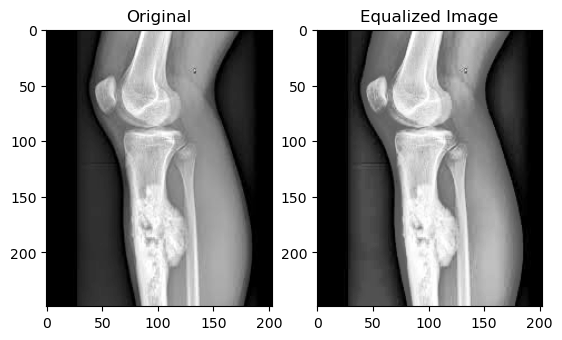

In [27]:
#Histogram equalization
equ=cv2.equalizeHist(testimg)

hist_original=cv2.calcHist([testimg],[0],None,[256],[0,256])
hist_equ=cv2.calcHist([equ],[0],None,[256],[0,256])

plt.subplot(121), plt.imshow(testimg, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(equ, cmap='gray'), plt.title('Equalized Image')


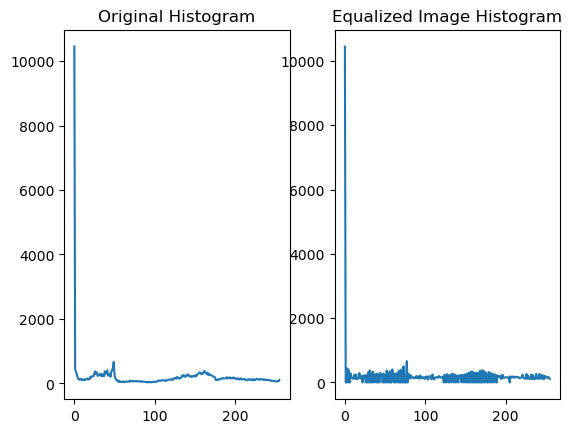

In [28]:
plt.subplot(121), plt.plot(hist_original), plt.title('Original Histogram')
plt.subplot(122), plt.plot(hist_equ), plt.title('Equalized Image Histogram')
plt.show()